In [1]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from scipy import stats
import matplotlib.patches as mpatches

sys.path.insert(1, '../')
# from SeasonalPlot_Functions import *

from MasterPlot_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   
cmap = mpl.colormaps['cmr.seaweed']  

In [2]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [3]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [4]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present'].copy()
future=df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

#### Change data

In [5]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur.csv")

In [6]:
df_changes_byduration['D_mean_present'] = df_changes_byduration['D_mean_present'].apply(lambda x: x + 365 if x < 50 else x)
df_changes_byduration['D_mean_future'] = df_changes_byduration['D_mean_future'].apply(lambda x: x + 365 if x < 50 else x)
df_changes_byduration['D_mean_diff'] = df_changes_byduration['D_mean_future'] - df_changes_byduration['D_mean_present']

#### Seasonal splits

In [7]:
df_changes_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_byduration_summer = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

df_changes_winter = df_changes_all_season[df_changes_all_season['season']=='Winter']
df_changes_byduration_winter = df_changes_byduration_season[df_changes_byduration_season['season']=='Winter']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# Storm characteristics

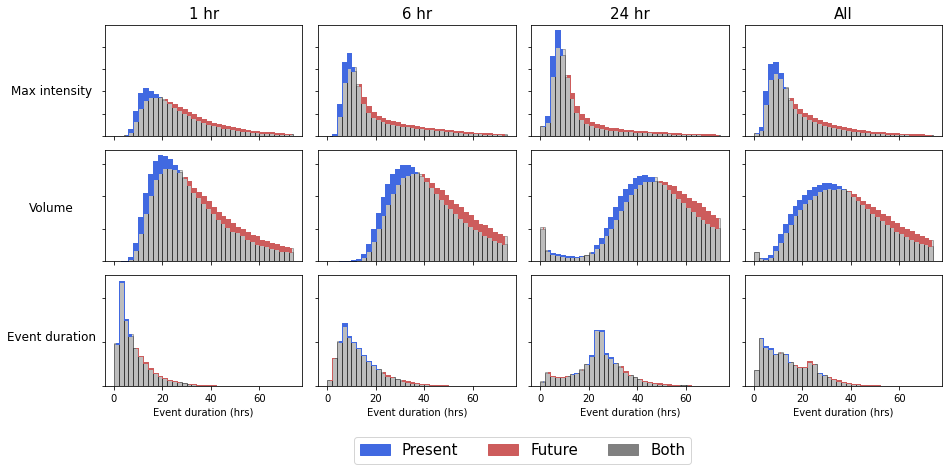

In [8]:
bin_edges_intensity = np.arange(0, 70 + 5, 2)
bin_edges_volume = np.arange(0, 135 + 5, 3)
bin_edges_duration = np.arange(0, 60 + 5,1)

durations = ['1', '6', '24']
alpha = 1
# Create a figure with subplots for different durations
n_categories = len(durations)
n_variables = 3
fig, axs = plt.subplots(n_categories, n_variables+1, figsize=(12, 2 * n_categories), sharex='col', sharey='row')  

# Call the function for each variable in each duration category
for i, duration in enumerate(durations):
    
    plot_histogram_with_shaded_difference(present_data=present, future_data=future, variable='max_intensity', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[0,i], bins=bin_edges_intensity, alpha=alpha)
    
    plot_histogram_with_shaded_difference(present_data=present, future_data=future, variable='Volume', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[1,i], bins=bin_edges_intensity, alpha=alpha)   
    
    plot_histogram_with_shaded_difference(present_data=present, future_data=future, variable='duration', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[2,i], bins=bin_edges_intensity, alpha=alpha)       

    # Set x-axis labels for the last row
    axs[2,0].set_xlabel("Event duration (hrs)", fontsize=10)
    axs[2,1].set_xlabel("Event duration (hrs)", fontsize=10)
    axs[2,2].set_xlabel("Event duration (hrs)", fontsize=10)
    axs[2,3].set_xlabel("Event duration (hrs)", fontsize=10)    
        
    axs[0,0].set_title("1 hr", fontsize=15)
    axs[0,1].set_title("6 hr", fontsize=15)
    axs[0,2].set_title("24 hr", fontsize=15)
    axs[0,3].set_title("All", fontsize=15)
    
    # axs[0,3].legend(loc='upper right')

for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_ylabel("")

# Add the all data    
plot_histogram_with_shaded_difference2(present_data=present, future_data=future, variable='max_intensity', 
    duration_variable="dur_for_which_this_is_amax", ax=axs[0,3], bins=bin_edges_intensity, alpha=alpha)       

plot_histogram_with_shaded_difference2(present_data=present, future_data=future, variable='Volume', 
    duration_variable="dur_for_which_this_is_amax", ax=axs[1,3], bins=bin_edges_intensity, alpha=alpha)       

plot_histogram_with_shaded_difference2(present_data=present, future_data=future, variable='duration', 
    duration_variable="dur_for_which_this_is_amax", ax=axs[2,3], bins=bin_edges_intensity, alpha=alpha)       

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='grey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.1],
           fontsize=15, ncol=4);

fig.text(-0.045, 0.78, 'Max intensity', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.51, 'Volume', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.21, 'Event duration', va='center', ha='center', fontsize=12, rotation='horizontal');

# Adjust layout to prevent overlap
plt.tight_layout()

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

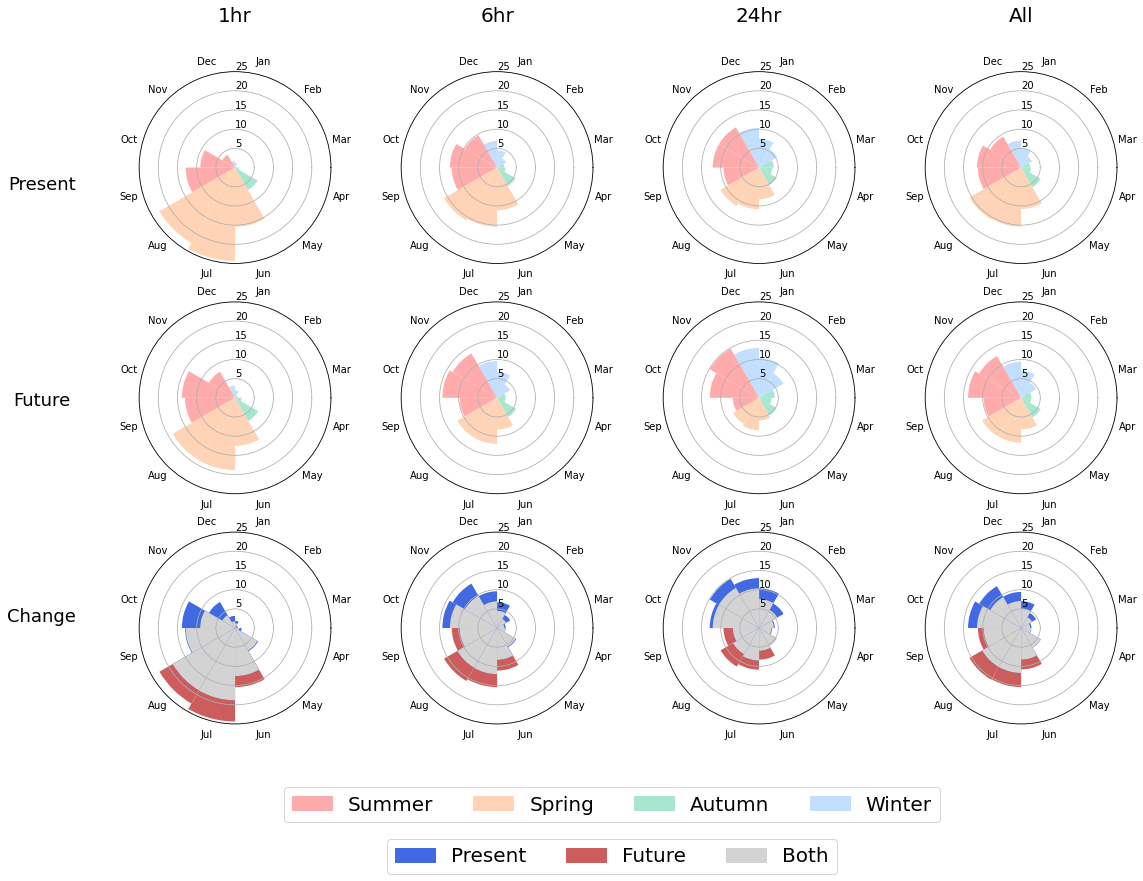

In [9]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'polar': True})

# # Loop through durations, axes, and titles
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(present, axes[0, 3], True, "All",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(future, axes[1,3], False, "Present (all)",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');


# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration_pres = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present, future, axes[2, 3], False, 'All', False, 25) 
fig.text(0.06, 0.25, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Create legend
winter_patch = mpatches.Patch(color='#C2DFFF', label='Winter')
autumn_patch = mpatches.Patch(color='#A8E6CF', label='Autumn')
spring_patch = mpatches.Patch(color='#FFD3B6', label='Spring')
summer_patch = mpatches.Patch(color='#FFABAB', label='Summer')

fig.legend(handles=[summer_patch, spring_patch, autumn_patch, winter_patch], loc = 'lower center', bbox_to_anchor=[0.5, 0],
           fontsize=20, ncol=4);

## Create legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.06],
           fontsize=20, ncol=4);

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Histogram of the days of year for 24h, before 

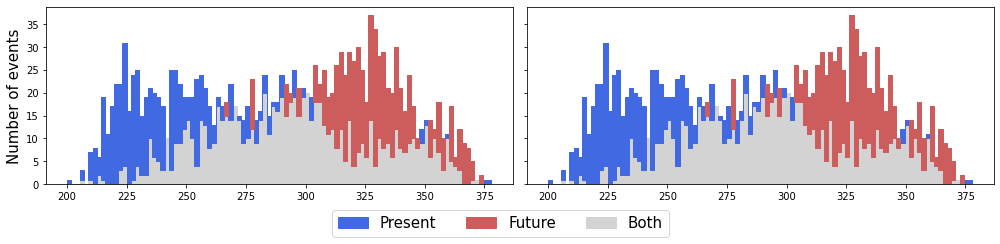

In [10]:
# Select data for a specific duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)].copy()

fig, axs = plt.subplots(ncols=2, figsize=(14, 3), sharey=True)

bins=100
# Plot histograms for both columns with overlap regions
plot_hist_with_overlap_shading(axs[0], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')

# Adjust for the second plot
this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)

plot_hist_with_overlap_shading(axs[1], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')
axs[0].set_ylabel('Number of events', fontsize=15)


## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.15],
           fontsize=15, ncol=4);

plt.tight_layout()

### Day of year - present, future, change

In [11]:
D_diffs, D_diffs_dict = find_significance_of_differences(present, future, 'D')

In [12]:
D50_diffs, D50_diffs_dict =find_significance_of_differences(present, future, 'D50_new')
# R_diffs, R_diffs_dict = find_significance_of_differences(present, future, 'R')

In [208]:
def plot_values_on_map_withsig(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    # Extract location data for plotting
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)
    
    # Identify points with and without significant values
    significant_points = data[data['sig'] == 1]
    nonsignificant_points = data[data['sig'] != 1]
    
    # Plot nonsignificant points without an outline
    ax.scatter(
        tbo_vals.loc[nonsignificant_points['gauge_num'], 'Lon'],
        tbo_vals.loc[nonsignificant_points['gauge_num'], 'Lat'],
        c=nonsignificant_points[value_column], cmap=cmap, edgecolor=None, alpha=1, s=5, marker='s',
        vmin=vmin, vmax=vmax
    )
    
    # Plot significant points with a black outline
    scatter = ax.scatter(
        tbo_vals.loc[significant_points['gauge_num'], 'Lon'],
        tbo_vals.loc[significant_points['gauge_num'], 'Lat'],
        c=significant_points[value_column], cmap=cmap, edgecolor='black', linewidth=1, alpha=1, s=5, marker='s',
        vmin=vmin, vmax=vmax
    )
    
    # Set title and remove axis tick labels
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return scatter

def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    gauge_locs = data['gauge_num'].copy()
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']

    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='darkgrey', edgecolor='black', linewidth=1)

    # Scatter plot for the specified value column
    scatter = ax.scatter(
        lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=1, s=5, marker='s',
        vmin=vmin, vmax=vmax
    )
    if 'present' in value_column:
        ax.set_title(title, fontsize=20)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    return scatter

In [209]:
def make_plot_D(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    # Apply the transformation to both present and future values
    df_changes_all[variable_present] = df_changes_all[variable_present].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all[variable_future] = df_changes_all[variable_future].apply(lambda x: x + 365 if x < 50 else x)
    
    df_changes_byduration[variable_present] = df_changes_byduration[variable_present].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_byduration[variable_future] = df_changes_byduration[variable_future].apply(lambda x: x + 365 if x < 50 else x)

    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
        

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Using the adjusted `low_lim` and `high_lim`
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', variable_present]]
        plot_values_on_map(axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present, low_lim, high_lim, cmap)

    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all[['gauge_num', variable_present, 'sig']], 'All', tbo_vals, variable_present, low_lim, high_lim, cmap)

    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('Day of year', fontsize=15)
    
    # Use FuncFormatter to apply the custom date format to the colorbar
    ticks = np.linspace(100, 375, num=6)  # Define ticks, covering both normal days and over 365
    cbar.set_ticks(ticks)  # Set ticks for the colorbar
    cbar.ax.tick_params(labelsize=16) 
    cbar.set_ticklabels([day_to_date(day) for day in ticks])  # Apply custom date formatting
    
#     cbar.set_ticks(np.linspace(190, 365, num=6))  # Set specific ticks
#     cbar.set_ticklabels([day_to_date(day) for day in np.linspace(190, 365, num=6)])  # Apply formatting    
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', variable_future]]
        plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)

    # Plot 'All' future values
    scatter = plot_values_on_map(axes[1, 3], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
    
    cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('Day of year', fontsize=15)
    
    # Use FuncFormatter to apply the custom date format to the colorbar
    ticks = np.linspace(100, 375, num=6)  # Define ticks, covering both normal days and over 365
    cbar.set_ticks(ticks)  # Set ticks for the colorbar
    cbar.ax.tick_params(labelsize=16) 
    cbar.set_ticklabels([day_to_date(day) for day in ticks])  # Apply custom date formatting
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    # Color map setup for difference plot
    colors = [(0, "blue"), (0.35, "lightblue"), (0.5, "white"), (0.7, "lightcoral"), (1, "red")]
    cmap_diff = LinearSegmentedColormap.from_list("custom_cmap", colors)    
    
    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    low_lim_diff = -80
    high_lim_diff = -low_lim_diff
    
    # Plot Difference Data if Available
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_diff']]
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        this_duration['sig'] =diffs_dict[duration] 
        scatter = plot_values_on_map_withsig(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff', low_lim_diff, high_lim_diff, cmap_diff)

    # Plot 'All' differences
    scatter = plot_values_on_map_withsig(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals, variable_diff, low_lim_diff, high_lim_diff, 'bwr')
    
    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    #cbar.set_label('Difference', fontsize=15)
    cbar.ax.tick_params(labelsize=16) 
    
    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')
    
    plt.subplots_adjust(hspace=-0.05)
    
    plt.tight_layout()


In [43]:
gauge_locs = df_changes_all['gauge_num'].copy()
gauge_locs = df_changes_all['gauge_num'].copy()
lon = tbo_vals.loc[gauge_locs, 'Lon']
lat = tbo_vals.loc[gauge_locs, 'Lat']
test_df = pd.DataFrame({'lat':lat, 'lon':lon, 'gauge_num':gauge_locs, 'D_mean_present': df_changes_all['D_mean_present']})

In [114]:
import iris
sys.path.insert(1, '../../FindingEvents/Finding_AMAX_Events')
from Identify_Events_Functions import *
from Prepare_Data_Functions import *

yrs_range = '2002_2020'
sample_yr = 2006
em='bc005'
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr{sample_yr}01.nc')[0][1,:,:]

In [23]:
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
gauge_num=1

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


TypeError: inner() got multiple values for argument 'ax'

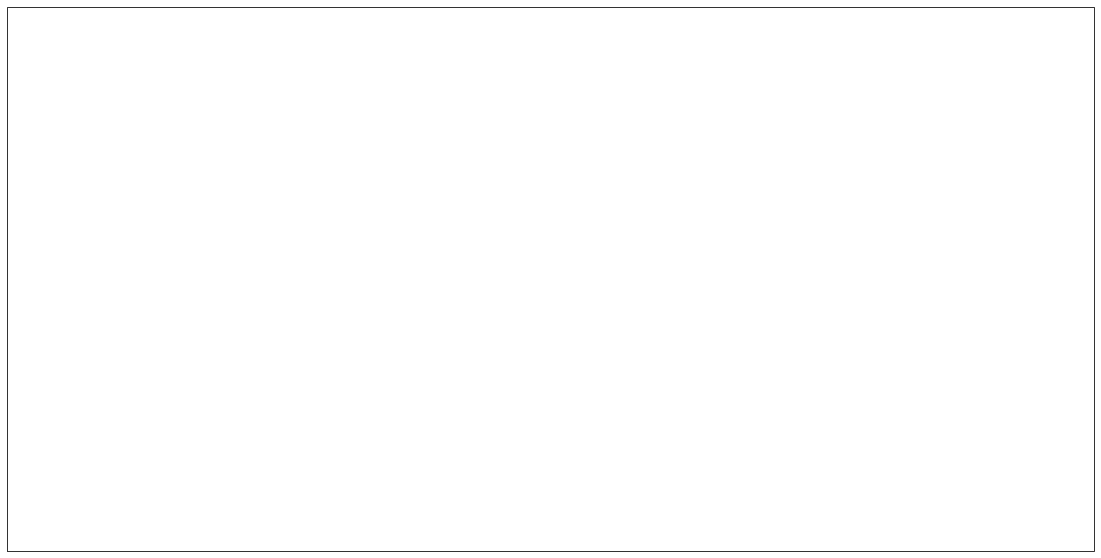

In [172]:
# Create the figure and axes for the plot with British National Grid projection (OSGB)
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the cube using iris quickplot, but on the specific axis (ax) with cartopy
# Use discrete levels, highlighting values of 1
levels = np.linspace(0, 1, 11)  # Adjust to a small range to focus on the 1s
iplt.contourf(sample_cube, levels=levels, cmap='viridis', ax=ax)

# Add the outline of the UK using cartopy's natural feature
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Add a colorbar and title
# plt.colorbar(ax.images[0], label="Value")
plt.title("Cube Values with UK Outline")

# Show the plot
plt.show()


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  # Remove the CWD from sys.path while we load stuff.
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


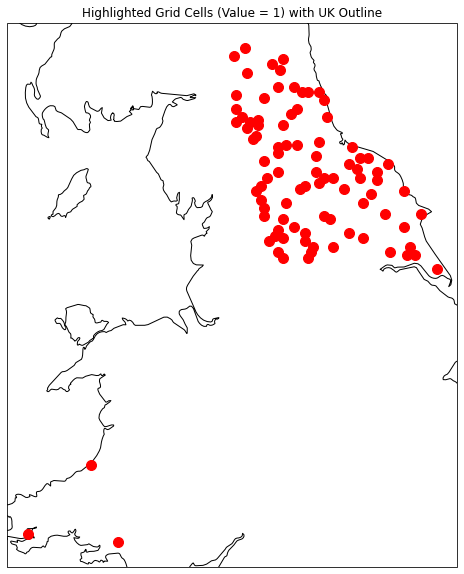

In [147]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Extract latitude and longitude from the cube
latitudes = sample_cube.coord('projection_y_coordinate').points
longitudes = sample_cube.coord('projection_x_coordinate').points

# Create the figure and axes for the plot with British National Grid projection (OSGB)
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.OSGB()})

# Plot the UK outline using Cartopy's natural feature
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Extract the coordinates where the value is 1
highlighted_points = np.where(sample_cube.data == 1)

# Plot those points as a scatter
ax.scatter(longitudes[highlighted_points[1]], latitudes[highlighted_points[0]], color='red', s=100, transform=ccrs.OSGB(), label='Highlighted Cells')

# Add a colorbar and title
plt.title("Highlighted Grid Cells (Value = 1) with UK Outline")

# Show the plot
plt.show()


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


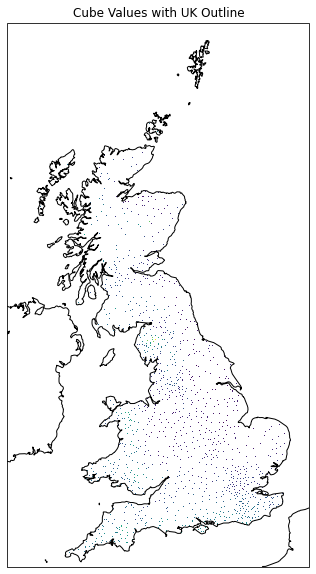

In [202]:
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr{sample_yr}01.nc')[0][1,:,:]
sample_cube.data = np.full(sample_cube.shape, np.nan)

for gauge_num in range(0,1293):
    if gauge_num not in [423, 444, 827, 888]:
        Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)

        this_gauge = test_df[test_df['gauge_num']==gauge_num].reset_index()
        D = this_gauge['D_mean_present'][0]
        sample_cube.data[idx_2d[0], idx_2d[1]] = D

import iris.quickplot as qplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axes for the plot with a specific coordinate reference system (CRS)
fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.OSGB()})

# Plot the cube using iris quickplot, but on the specific axis (ax) with cartopy
iplt.pcolormesh(sample_cube)

# Add the outline of the UK using cartopy's natural feature
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Add a colorbar and title
# plt.colorbar(ax.images[0], label="Value")
plt.title("Cube Values with UK Outline")
# plt.gca().gridlines(draw_labels=True)
# Show the plot
plt.show()

In [45]:
Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)

(89, 340)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


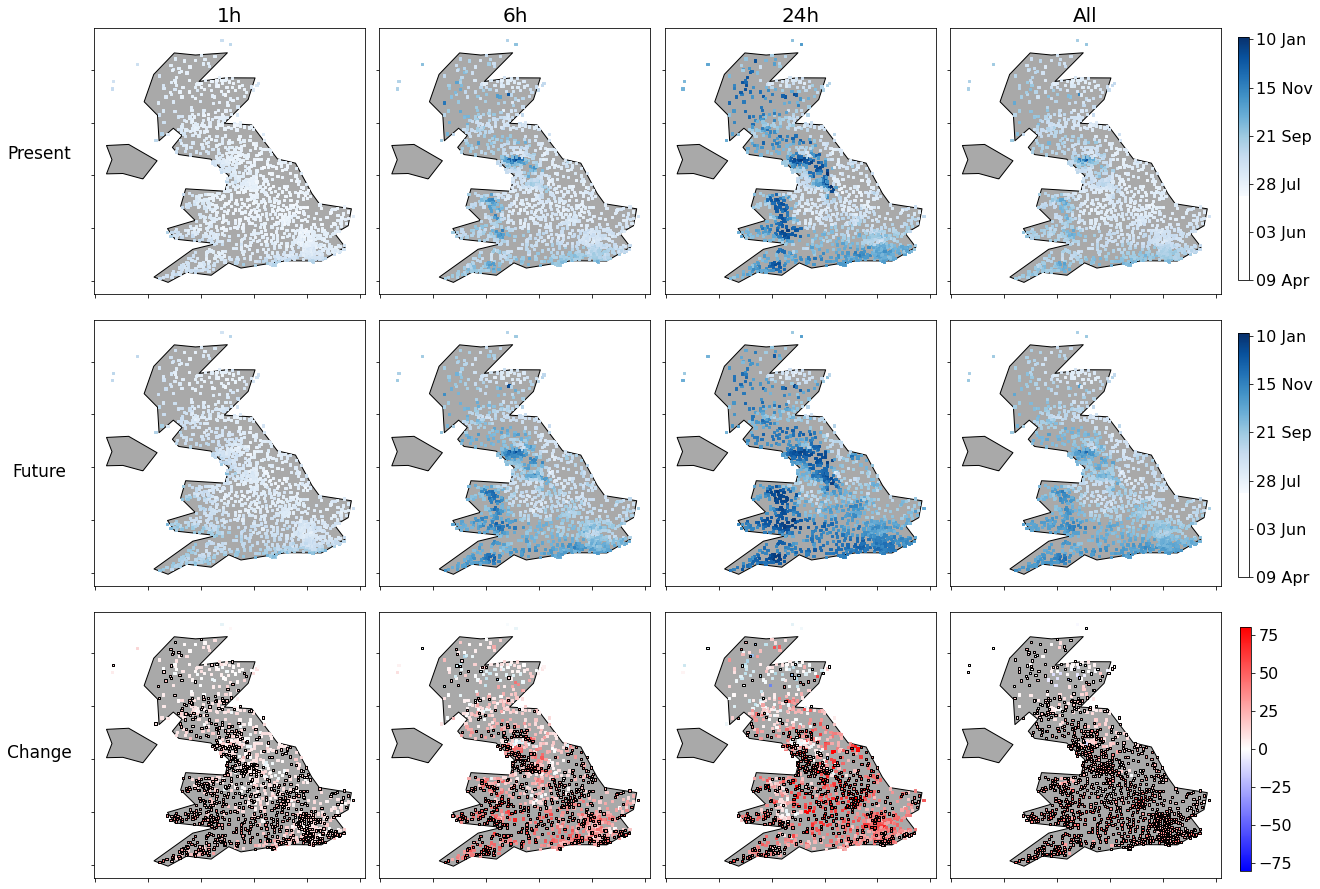

In [210]:
make_plot_D(df_changes_all, df_changes_byduration, 'D_mean','Blues', D_diffs_dict )

###  R (how dispersed events are) - present, future change

In [16]:
# make_plot(df_changes_all, df_changes_byduration, 'R', 'inferno')

# Loading analysis

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'D50_P90', 'RdYlGn') # PiYG #PuBuGn
# make_plot(df_changes_all, df_changes_byduration, 'D50_P10', 'RdYlGn_R') # PiYG #PuBuGn

In [61]:
df_changes_all_test=df_changes_all.copy()


In [62]:
df_changes_all = df_changes_all[:10]

In [63]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

# Load your data (assuming df_changes_all is already loaded in your environment)
# df_changes_all = pd.read_csv("your_data.csv")  # Uncomment if you need to load the data

# Run paired t-test for each location and store the p-values
p_values = []

for i, row in df_changes_all.iterrows():
    present = row['D50_mean_present']
    
    future = row['D50_mean_future']
    print(present, future)
    # Perform paired t-test or Wilcoxon test
    # T-test example:
    t_stat, p_value = ttest_rel([present], [future])
    
    # Alternatively, for non-parametric data use Wilcoxon signed-rank test:
    # _, p_value = wilcoxon([present], [future])
    
    p_values.append(p_value)

# Add p-values to the dataframe
df_changes_all['p_value'] = p_values

# Apply FDR correction for multiple comparisons
_, corrected_p_values, _, _ = multipletests(df_changes_all['p_value'], alpha=0.05, method='fdr_bh')

# Add corrected p-values to the dataframe
df_changes_all['corrected_p_value'] = corrected_p_values

# Determine significance based on the corrected p-value
df_changes_all['significant'] = df_changes_all['corrected_p_value'] < 0.05

t_stat, p_value = ttest_rel([present], [future])

# Alternatively, for non-parametric data use Wilcoxon signed-rank test:
# _, p_value = wilcoxon([present], [future])

p_values.append(p_value)

49.674087437761415 50.924920760522895
48.26298522604107 50.88955965013324
49.32502149069923 50.032385216359735
50.7730402644185 50.72740769381538
50.335718346535664 51.16524500101218
47.90870525498658 51.67270184705972
49.67856974242599 49.141929948252645
50.40342836827195 49.7325080823425
47.10232296452839 48.83525347811742
49.86047594550487 50.112835618127626


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [68]:
future

50.112835618127626

In [69]:
df_changes_all[['D50_mean_present', 'D50_mean_future']]
present = 49.86
future = 50.11
t_stat, p_value = ttest_rel([present], [future])
t_stat, p_value 

(nan, nan)

In [40]:
# Perform paired t-test for overall significance
t_stat, overall_p_value = ttest_rel(df_changes_all['D_mean_present'], df_changes_all['D_mean_future'])
print(f"Overall significance p-value: {overall_p_value}", t_stat)

Overall significance p-value: 0.0 -75.20960262883159


(array([0, 1]), array([1117,  174]))


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


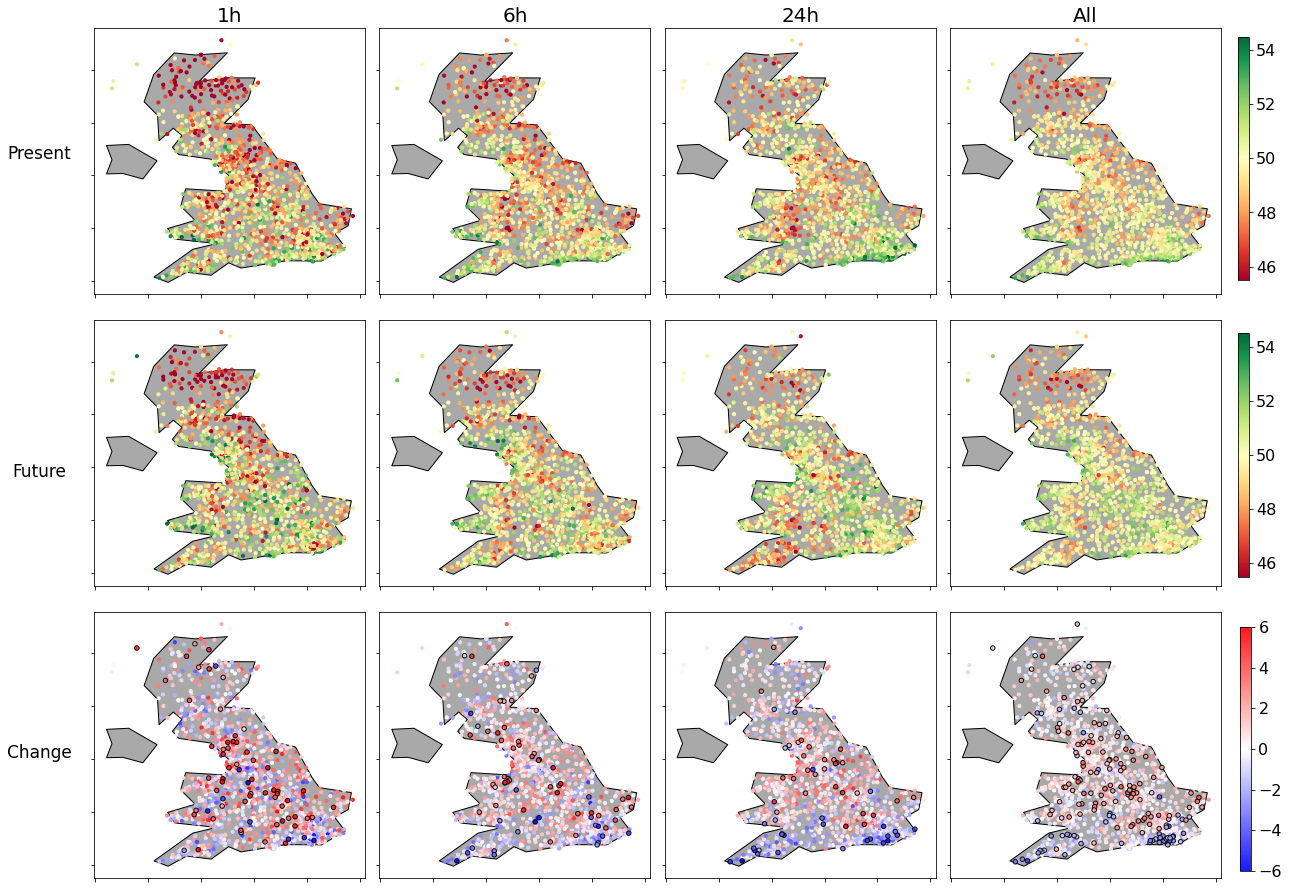

In [31]:
make_plot(df_changes_all, df_changes_byduration, 'D50_mean', 'RdYlGn', D50_diffs_dict) 

## Distribution of values

In [ ]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

# Example bins
bins = 5

# Plot D50 histogram with overlap
plot_hist_with_overlap_shading(axs[1], present['D50_new'], future['D50_new'], bins=bins)
axs[1].set_xlabel("$D_{50}$", fontsize=15)
axs[0].set_ylabel('Proportion', fontsize=15)

# Repeat for max_quintile_molly
plot_hist_with_overlap_shading(axs[0], present['max_quintile_molly'], future['max_quintile_molly'], bins=bins)
axs[0].set_xlabel('Quintile classification', fontsize=15)

# Create custom legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
overlap_patch = mpatches.Patch(color='lightgrey', label='Overlap')
fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.15])

# Calculate bin edges and centers for x-tick positioning
counts, bin_edges = np.histogram(present['max_quintile_molly'], bins=5)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
axs[0].set_xticks(bin_centers)
axs[0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.tight_layout()
plt.show()


## Roberto style analysis

In [ ]:
# Apply the function to the Age column using the apply() function
present['D50_loading'] = present['D50'].apply(categorise_D50)
future['D50_loading'] = future['D50'].apply(categorise_D50)

In [ ]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future}
short_ids = ['Present (UKCP18)', 'Future (UKCP18)']

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
        quintile_cats, color_mapping,  short_ids[i])

In [ ]:
quintile_mapping = {1: 'F', 2: 'B'}
quintile_cats = ['F', 'B']
color_mapping = {'F': (0.0, 0.0, 1.0, 0.6), 'B': (0.5451, 0.0, 0.0, 0.6)}

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'D50_loading', 
        quintile_cats, color_mapping,  short_ids[i])

## Add version for different durations

## Comparing methods

In [ ]:
df_long = df_long.sort_values('Loading_profile_molly')
df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

In [ ]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# fig, axs = plt.subplots(figsize=(8,4))
# plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
# plt.show()

### With seasonal split

In [ ]:
# Define custom order for Loading_profile_molly and season
loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# Create a mapping for custom orders
loading_mapping = {value: index for index, value in enumerate(loading_order)}
season_mapping = {value: index for index, value in enumerate(season_order)}

# Add new columns to the DataFrame for sorting
present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
present['Season_order'] = present['season'].map(season_mapping)

# Sort the DataFrame by the new order columns
present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# Drop the temporary sorting columns
present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
fig, axs = plt.subplots(figsize=(12,8))
plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)

### D50 vs Tb0

In [ ]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time', 'Lon', 'Lat']], on='gauge_num', how='left')

## D50 vs Day of year

In [ ]:
df_changes_all_test =df_changes_all.copy()
df_changes_byduration_test = df_changes_byduration.copy()

In [ ]:
# variable = 'D50_P90'
# variable = 'D50_P10'

In [ ]:
durations =[1,6,24]
variable = 'B2_percentage'
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num], this_duration['D_mean_present'],this_duration[f'{variable}_present'], "Day of year", "B2 %", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all_test["D_mean_present"],  df_changes_all_test[f'{variable}_present'],"Day of year", "B2 %", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration[f'{variable}_future'], "Day of year", "B2 %" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3], df_changes_all_test['D_mean_future'], df_changes_all_test[f'{variable}_future'],  "Day of year", "B2 %" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

In [ ]:
durations =[1,6,24]
variable = 'F2_percentage'
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num],this_duration['D_mean_present'], this_duration[f'{variable}_present'],  "Day of year", "F2 %", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all["D_mean_present"], df_changes_all[f'{variable}_present'], "Day of year", "F2 %", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration[f'{variable}_future'],"Day of year", "F2 %" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3],  df_changes_all['D_mean_future'], df_changes_all[f'{variable}_future'], "Day of year", "F2 %" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

In [ ]:
durations =[1,6,24]
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', 'D50_mean_present', 'D_mean_present']]
    plot_contour(axes[0, ax_num], this_duration['D_mean_present'], this_duration['D50_mean_present'], "Day of year", "Mean $D_{50}$", f"{duration}hrs" )
plot_contour(axes[0, 3], df_changes_all['D_mean_present'], df_changes_all['D50_mean_present'],"Day of year", "Mean $D_{50}$", "All"  )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', 'D50_mean_future', 'D_mean_future']]
    plot_contour(axes[1, ax_num], this_duration['D_mean_future'], this_duration['D50_mean_future'],"Day of year", "Mean $D_{50}$" , f"{duration}hrs", 'Reds')   
plot_contour(axes[1, 3], df_changes_all['D_mean_future'], df_changes_all['D50_mean_future'], "Day of year", "Mean $D_{50}$" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   

## Plot contour plot of all events against the day of year they occurred

In [ ]:
# def plot_contour_all_events(ax, data_x, data_y, title, cmap='Blues'):
#     # Create a grid for the contour plot
#     x_grid = np.linspace(data_x.min(), data_x.max(), 100)
#     y_grid = np.linspace(data_y.min(), data_y.max(), 100)
#     X, Y = np.meshgrid(x_grid, y_grid)

#     # Perform Kernel Density Estimation (KDE)
#     kde = gaussian_kde([data_x, data_y])
#     Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

#     # Normalize the density values to be between 0 and 1
#     Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

#     # Create the contour plot with fixed color limits between 0 and 1
#     contour = ax.contourf(X, Y, Z_normalized, levels=10, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
# #     cbar = fig.colorbar(contour, ax=ax)
# #     cbar.set_label('Density (normalized)')

#     # Calculate R^2 and p-value
#     slope, intercept, r_value, p_value, std_err = linregress(data_x, data_y)
#     r_squared = r_value**2

#     # Set labels and title
#     # ax.set_xlabel('%' if ax in [axs[1, 0], axs[1, 1]] else '')
#     ax.set_ylabel("$D_{50}$",fontsize=18)
#     ax.set_xlim(0,366)
#     ax.set_ylim(0,6)

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Present", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Blues' )
axs[1].set_xlabel('Day of Year', fontsize=18);

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

df = future

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Reds' )
axs[1].set_xlabel('Day of Year', fontsize=18);

## Another option: 

In [ ]:
durations =[1,6,24]
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False, sharex=False)
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_contour(axes[0, ax_num], this_duration['D'], this_duration['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs" )
plot_contour(axes[0, 3], present['D'], present['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs" )
fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_contour(axes[1, ax_num], this_duration['D'], this_duration['D50_new'], "", "Mean $D_{50}$", f"{duration}hrs", "Reds" )
plot_contour(axes[1, 3], future['D'], future['D50_new'], "Day of year", "Mean $D_{50}$" ,"All" , 'Reds')
fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   